# CCE Moorings and MITgcm - Temporal Scales Analysis  

**Purpose**: Code for comparing the CCE mooring scale analysis with the MITgcm model output.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_obs           = 'CTD'  # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, doxy, chla, density
option_depth         = 0.5    # Specifies the depth level in meter at which the decorrelation data was computed

# Set time and space parameters
T               = 1*(60)*(60)                         # Spcifies the time interval for model run. Units: seconds
estimator       = 'biased'                            # Specifies the approach for estimating the autocorrelation function  
event_time_bnds_CCE1 = [datetime(2016, 1, 1, 0, 0, 0), datetime(2017, 12, 31, 23, 59, 59)]  # Specifies the event period
event_time_bnds_CCE2 = [datetime(2019, 1, 1, 0, 0, 0), datetime(2020, 12, 31, 23, 59, 59)]  # Specifies the event period
event_time_bnds_CCE3 = [datetime(2025, 3, 12, 0, 0, 0), datetime(2025, 6, 23, 0, 0, 0)]  # Specifies the event period
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze
M = 20

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load CCE intermediate data and mitgcm time scale analysis data

In [4]:
#--- MITgcm Data ---# 
ROOT_mitgcm = "/data/mitgcm/SWOT_MARA_RUN4_LY"
if option_var == 'temp':
    filename_decor   = PATH + ROOT_mitgcm + "/mitgcm_temporal_decorr_scale_temp_depth_" + str(option_depth) + "m.npz"
    filename_spectra = PATH + ROOT_mitgcm + "/mitgcm_temporal_psd_temp_depth_" + str(option_depth) + "m_numWindows_" + str(M) + ".npz"
elif option_var == 'sal':
    filename_decor   = PATH + ROOT_mitgcm + "/mitgcm_temporal_decorr_scale_sal_depth_" + str(option_depth) + "m.npz"
    filename_spectra = PATH + ROOT_mitgcm + "/mitgcm_temporal_psd_sal_depth_" + str(option_depth) + "m_numWindows_" + str(M) + ".npz"
elif option_var == 'density':
    filename_decor   = PATH + ROOT_mitgcm + "/mitgcm_temporal_decorr_scale_rho_depth_" + str(option_depth) + "m.npz"
    filename_spectra = PATH + ROOT_mitgcm + "/mitgcm_temporal_psd_rho_depth_" + str(option_depth) + "m_numWindows_" + str(M) + ".npz"

# Load data 
ds_decor   = np.load(filename_decor, allow_pickle=True)
ds_spectra = np.load(filename_spectra, allow_pickle=True)

# Extract data variables
lon_m             = ds_decor["lon"]
lat_m             = ds_decor["lat"]
time_scale_m      = ds_decor["time_scale"]   # Units: Seconds
autocorr_m        = ds_decor["autocorr"] 
Lt_m              = ds_decor["L_tm"]          # Units: Months

f_m               = ds_spectra["f"]          # Units: Hz
S_m               = ds_spectra["S"]
CI_m              = ds_spectra["CI"]

#--- CCE Scale Analysis Data ---# 
filename_CCE1 = PATH + "/data/CCE/CCE1/" + option_obs + "/CCE1_" + option_obs + "_" + str(event_time_bnds_CCE1[0].year) + str(event_time_bnds_CCE1[0].month) + str(event_time_bnds_CCE1[0].day) +  "-" + str(event_time_bnds_CCE1[1].year) + str(event_time_bnds_CCE1[1].month) + str(event_time_bnds_CCE1[1].day) + "_scale_data_gridded.npz"
filename_CCE1_grid = PATH + "/data/CCE/CCE1/" + option_obs + "/CCE1_" + option_obs + "_" + str(event_time_bnds_CCE1[0].year) + str(event_time_bnds_CCE1[0].month) + str(event_time_bnds_CCE1[0].day) +  "-" + str(event_time_bnds_CCE1[1].year) + str(event_time_bnds_CCE1[1].month) + str(event_time_bnds_CCE1[1].day) + "_scale_data.npz"
filename_CCE2 = PATH + "/data/CCE/CCE2/" + option_obs + "/CCE2_" + option_obs + "_" + str(event_time_bnds_CCE2[0].year) + str(event_time_bnds_CCE2[0].month) + str(event_time_bnds_CCE2[0].day) +  "-" + str(event_time_bnds_CCE2[1].year) + str(event_time_bnds_CCE2[1].month) + str(event_time_bnds_CCE2[1].day) + "_scale_data.npz"
filename_CCE3 = PATH + "/data/CCE/CCE3/" + option_obs + "/CCE3_" + option_obs + "_" + str(event_time_bnds_CCE3[0].year) + str(event_time_bnds_CCE3[0].month) + str(event_time_bnds_CCE3[0].day) +  "-" + str(event_time_bnds_CCE3[1].year) + str(event_time_bnds_CCE3[1].month) + str(event_time_bnds_CCE3[1].day) + "_scale_data.npz"

# Load data 
ds_decor_CCE1   = np.load(filename_CCE1, allow_pickle=True)
ds_decor_CCE2   = np.load(filename_CCE2, allow_pickle=True)
ds_decor_CCE3   = np.load(filename_CCE3, allow_pickle=True)

# Extract data variables

#--- CCE1 ---# 
lon1_nc          = ds_decor_CCE1["lon"]
lat1             = ds_decor_CCE1["lat"]
depth1           = ds_decor_CCE1["depth"]

if option_var == 'temp':
    autocorr1   = ds_decor_CCE1["autocorr_temp"] 
    time_scale1 = ds_decor_CCE1["time_scale_temp"] # Units: Seconds
    Lt1         = ds_decor_CCE1["Lt_temp"]         # Units: days
    S1          = ds_decor_CCE1["S_temp"] 
    CI1         = ds_decor_CCE1["CI_temp"]
    f1          = ds_decor_CCE1["f_temp"]          # Units: Hz
elif option_var == 'sal':
    autocorr1   = ds_decor_CCE1["autocorr_sal"] 
    time_scale1 = ds_decor_CCE1["time_scale_sal"] 
    Lt1         = ds_decor_CCE1["Lt_sal"]
    S1          = ds_decor_CCE1["S_sal"] 
    CI1         = ds_decor_CCE1["CI_sal"]
    f1          = ds_decor_CCE1["f_sal"]
elif option_var == 'density':
    autocorr1   = ds_decor_CCE1["autocorr_rho"] 
    time_scale1 = ds_decor_CCE1["time_scale_rho"] 
    Lt1         = ds_decor_CCE1["Lt_rho"]
    S1          = ds_decor_CCE1["S_rho"] 
    CI1         = ds_decor_CCE1["CI_rho"]
    f1          = ds_decor_CCE1["f_rho"]

#--- CCE2 ---# 
lon2_nc          = ds_decor_CCE2["lon"]
lat2             = ds_decor_CCE2["lat"]
depth2           = ds_decor_CCE2["depth"]

if option_var == 'temp':
    autocorr2   = ds_decor_CCE2["autocorr_temp"] 
    time_scale2 = ds_decor_CCE2["time_scale_temp"] 
    Lt2         = ds_decor_CCE2["Lt_temp"]
    S2          = ds_decor_CCE2["S_temp"] 
    CI2         = ds_decor_CCE2["CI_temp"]
    f2          = ds_decor_CCE2["f_temp"]
elif option_var == 'sal':
    autocorr2   = ds_decor_CCE2["autocorr_sal"] 
    time_scale2 = ds_decor_CCE2["time_scale_sal"] 
    Lt2         = ds_decor_CCE2["Lt_sal"]
    S2          = ds_decor_CCE2["S_sal"] 
    CI2         = ds_decor_CCE2["CI_sal"]
    f2          = ds_decor_CCE2["f_sal"]
elif option_var == 'density':
    autocorr2   = ds_decor_CCE2["autocorr_rho"] 
    time_scale2 = ds_decor_CCE2["time_scale_rho"] 
    Lt2         = ds_decor_CCE2["Lt_rho"]
    S2          = ds_decor_CCE2["S_rho"] 
    CI2         = ds_decor_CCE2["CI_rho"]
    f2          = ds_decor_CCE2["f_rho"]

#--- CCE3 ---# 
lon3_nc          = ds_decor_CCE3["lon"]  #-120.53833
lat3             = ds_decor_CCE3["lat"]  #34.448473
depth3           = ds_decor_CCE2["depth"]

if option_var == 'temp':
    autocorr3   = ds_decor_CCE3["autocorr_temp"] 
    time_scale3 = ds_decor_CCE3["time_scale_temp"] 
    Lt3         = ds_decor_CCE3["Lt_temp"]
    S3          = ds_decor_CCE3["S_temp"] 
    CI3         = ds_decor_CCE3["CI_temp"]
    f3          = ds_decor_CCE3["f_temp"]
elif option_var == 'sal':
    autocorr3   = ds_decor_CCE3["autocorr_sal"] 
    time_scale3 = ds_decor_CCE3["time_scale_sal"] 
    Lt3         = ds_decor_CCE3["Lt_sal"]
    S3          = ds_decor_CCE3["S_sal"] 
    CI3         = ds_decor_CCE3["CI_sal"]
    f3          = ds_decor_CCE3["f_sal"]
elif option_var == 'density':
    autocorr3   = ds_decor_CCE3["autocorr_rho"] 
    time_scale3 = ds_decor_CCE3["time_scale_rho"] 
    Lt3         = ds_decor_CCE3["Lt_rho"]
    S3          = ds_decor_CCE3["S_rho"] 
    CI3         = ds_decor_CCE3["CI_rho"]
    f3          = ds_decor_CCE3["f_rho"]

# Convert the longitude value of the cce data
lon1 = lon1_nc % 360
lon2 = lon2_nc % 360
lon3 = lon3_nc % 360

# Convert decorrelation scale to days
Lt_mdays = Lt_m*(30)

In [5]:
print(lat1)
print(lat2)
print(lat3)

print(lon1_nc)
print(lon2_nc)
print(lon3_nc)

33.457
[34.3075]
34.44825228022894
-122.52233
[-120.8042]
-120.53825701527784


Read in bathymetry data

In [7]:
# Load bathymetry data 
filename = PATH_bathy + "topo_25.1.nc"
ds_bathy = xr.open_dataset(filename, engine="netcdf4")

# Extract data variables
lon_b = ds_bathy["lon"]  # Longitude
lat_b = ds_bathy["lat"]  # Latitude
bathy = ds_bathy["z"]    # Elevation/Bathymetry

# Convert convesion of longitude (neg from the prime meridian to positive definite wrapping around the earth)
lon_n = lon_b % 360

# Set max and min values 
lon_min = lon_bnds[0]
lon_max = lon_bnds[1]
lat_min = lat_bnds[0]
lat_max = lat_bnds[1]

# Extract data from bathymetry 
lon_grid = lon_n[(lon_n >= lon_min) & (lon_n <= lon_max)]
lat_grid = lat_b[(lat_b >= lat_min) & (lat_b <= lat_max)]
bathy_grid   = bathy[(lat_b >= lat_min) & (lat_b <= lat_max),(lon_n >= lon_min) & (lon_n <= lon_max)]

Now compare observations with model output

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_10791/3303554116.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


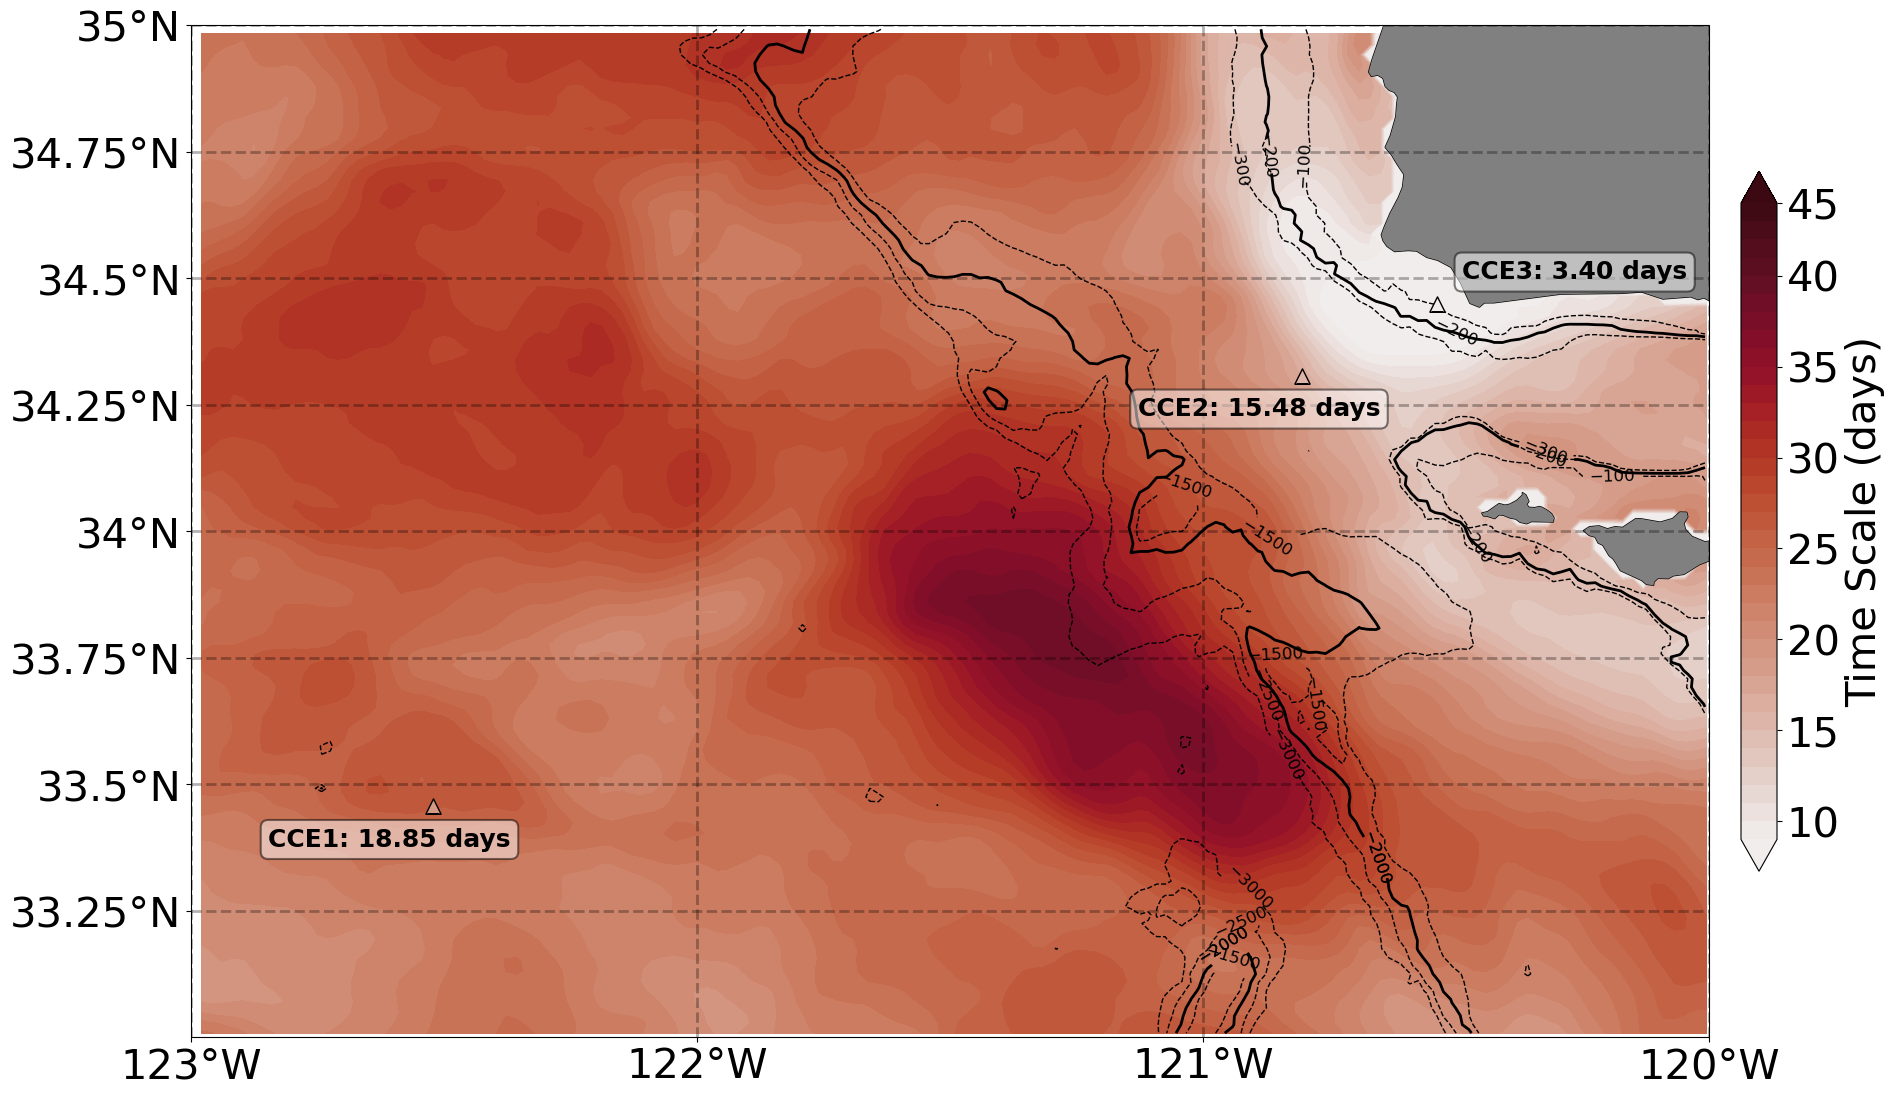

In [19]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-123, -122, -121, -120]
yticks = [33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75, 35.00]
resolution = "10m"
bounds = np.arange(0,360+40,40)
lon_min = -123
lon_max = -120
lat_min = 33
lat_max = 35
levels = np.arange(9,45,1) 

# Create figure
fig, axes = plt.subplots(1,1, figsize=(18, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max) 

# Plot temporal decorrelation scale
mesh = axes.contourf(
    lon_m, lat_m, Lt_mdays, levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.amp,  
    shading="auto", 
    extend = 'both'
)

# Define the same normalization used for the contourf plot
norm = mcolors.Normalize(vmin=levels.min(), vmax=levels.max())

#--- CCE1 ---# 

# Plot the mooring point with matching color
axes.scatter(
    lon1, lat1, 
    color=cmocean.cm.amp(norm(Lt1[0])),  # color from the same colormap
    edgecolor='black', marker='^', s=120,  # customize as needed
    transform=ccrs.PlateCarree(),
    zorder=10,
    label='Mooring'
)

# Add a label next to the mooring marker
axes.text(
    lon1 - 0.325, lat1 - 0.08,           # Slight offset to avoid overlapping the point
    f"CCE1: {Lt1[0]:.2f} days",                # Text label showing decorrelation scale in months
    transform=ccrs.PlateCarree(),
    fontsize=18,
    fontweight='bold',
    color='black',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1.5, alpha=0.5),
    zorder=11
)

#--- CCE2 ---# 

# Plot the mooring point with matching color
axes.scatter(
    lon2, lat2, 
    color=cmocean.cm.amp(norm(Lt2[0])),  # color from the same colormap
    edgecolor='black', marker='^', s=120,  # customize as needed
    transform=ccrs.PlateCarree(),
    zorder=10,
    label='Mooring'
)

# Add a label next to the mooring marker
axes.text(
    lon2 - 0.325, lat2 - 0.08,           # Slight offset to avoid overlapping the point
    f"CCE2: {Lt2[0]:.2f} days",                # Text label showing decorrelation scale in months
    transform=ccrs.PlateCarree(),
    fontsize=18,
    fontweight='bold',
    color='black',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1.5, alpha=0.5),
    zorder=11
)

#--- CCE3 ---# 

# Plot the mooring point with matching color
axes.scatter(
    lon3, lat3, 
    color= cmocean.cm.amp(norm(Lt3[0])),  # color from the same colormap
    edgecolor='black', marker='^', s=120,  # customize as needed
    transform=ccrs.PlateCarree(),
    zorder=10,
    label='Mooring'
)

# Add a label next to the mooring marker
axes.text(
    lon3 + 0.05, lat3 + 0.05,           # Slight offset to avoid overlapping the point
    f"CCE3: {Lt3[0]:.2f} days",            # Text label showing decorrelation scale in months
    transform=ccrs.PlateCarree(),
    fontsize=18,
    fontweight='bold',
    color='black',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1.5, alpha=0.5),
    zorder=11
)

# Plot depth contour lines
level_innershelf = np.arange(-300,0,100)
levels_midshelf = np.arange(-3000,-1000,500)
contour1 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=levels_midshelf, colors='black', linewidths=1, linestyles='dashed')
contour2 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=2, linestyles='solid')
contour3 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=level_innershelf, colors='black', linewidths=1, linestyles='dashed')
contour4 = axes.contour(lon_grid, lat_grid, bathy_grid,levels=[-200], colors='black', linewidths=2, linestyles='solid')
plt.clabel(contour1, fontsize=12)
plt.clabel(contour2, fontsize=12)
plt.clabel(contour3, fontsize=12)
plt.clabel(contour4, fontsize=12)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=30,
    color="black",
)

# Create colormap
cax = plt.axes([0.97, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=r'Time Scale (days)',
    nbins=10,
    fontsize=30,
    cbar_ticks=[np.array([10, 15, 20, 25, 30, 35, 40, 45]),np.array([10, 15, 20, 25, 30, 35, 40, 45])],
    task="custom ticks",
)


# Display figure
plt.tight_layout()
plt.show()

Grab data from near the moorings

In [ ]:
# Find the spatial indices of the longitude and latitude point
idx_lon_cce1 = np.argmin(np.abs(lon_m - lon1))
idx_lat_cce1 = np.argmin(np.abs(lat_m - lat1))

idx_lon_cce2 = np.argmin(np.abs(lon_m - lon2))
idx_lat_cce2 = np.argmin(np.abs(lat_m - lat2))

idx_lon_cce3 = np.argmin(np.abs(lon_m - lon3))
idx_lat_cce3 = np.argmin(np.abs(lat_m - lat3))

# Extract data 
time_scale_mc1      = np.squeeze(time_scale_m[:,idx_lat_cce1,idx_lon_cce1])
autocorr_mc1        = np.squeeze(autocorr_m[:,idx_lat_cce1,idx_lon_cce1])
Lt_mc1              = np.squeeze(Lt_mdays[idx_lat_cce1,idx_lon_cce1])
S_mc1               = np.squeeze(S_m[:,idx_lat_cce1,idx_lon_cce1])
CI_mc1              = np.squeeze(CI_m[:,:,idx_lat_cce1,idx_lon_cce1])

time_scale_mc2      = np.squeeze(time_scale_m[:,idx_lat_cce2,idx_lon_cce2])
autocorr_mc2        = np.squeeze(autocorr_m[:,idx_lat_cce2,idx_lon_cce2])
Lt_mc2              = np.squeeze(Lt_mdays[idx_lat_cce2,idx_lon_cce2])
S_mc2               = np.squeeze(S_m[:,idx_lat_cce2,idx_lon_cce2])
CI_mc2              = np.squeeze(CI_m[:,:,idx_lat_cce2,idx_lon_cce2])

time_scale_mc3      = np.squeeze(time_scale_m[:,idx_lat_cce3,idx_lon_cce3])
autocorr_mc3        = np.squeeze(autocorr_m[:,idx_lat_cce3,idx_lon_cce3])
Lt_mc3              = np.squeeze(Lt_mdays[idx_lat_cce3,idx_lon_cce3])
S_mc3               = np.squeeze(S_m[:,idx_lat_cce3,idx_lon_cce3])
CI_mc3              = np.squeeze(CI_m[:,:,idx_lat_cce3,idx_lon_cce3])

Compute the inertial frequency and the frequency associated with the decorrelation scale

In [ ]:
# Multiply the decorrelation scale by pi so that it is comparable to the period of a signal
T1 = Lt1[0]
T1m = Lt_mc1
T2 = Lt2[0]
T2m = Lt_mc2
T3 = Lt3[0]
T3m = Lt_mc3

# Compute its associated frequency in units of cpd 
f_decor1 = 1/T1
f_decor1m = 1/T1m
f_decor2 = 1/T2
f_decor2m = 1/T2m
f_decor3 = 1/T3
f_decor3m = 1/T3m

# Compute the interial period in units of cpd
omega = (7.2921*10**(-5))/(2*np.pi)                                # Units: Hz 
f_inertial = 2*omega*np.sin(np.deg2rad(np.mean(lat_m)))*(86400)    # Units: cpd

Compare autocorrelation functions and spectra

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31098/641039252.py:86: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[1].loglog(f_mcpd[1:], S_mc1[1:], '.-', color='tab:green', linewidth=1.5, markersize=2, linestyle='--')
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31098/641039252.py:105: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[1].loglog(f_mcpd[1:], S_mc2[1:], '.-', color='tab:red', linewidth=1.5, markersize=2, linestyle='--')
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31098/641039252.py:124: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[1].loglog(f_mcpd[1:], S_mc

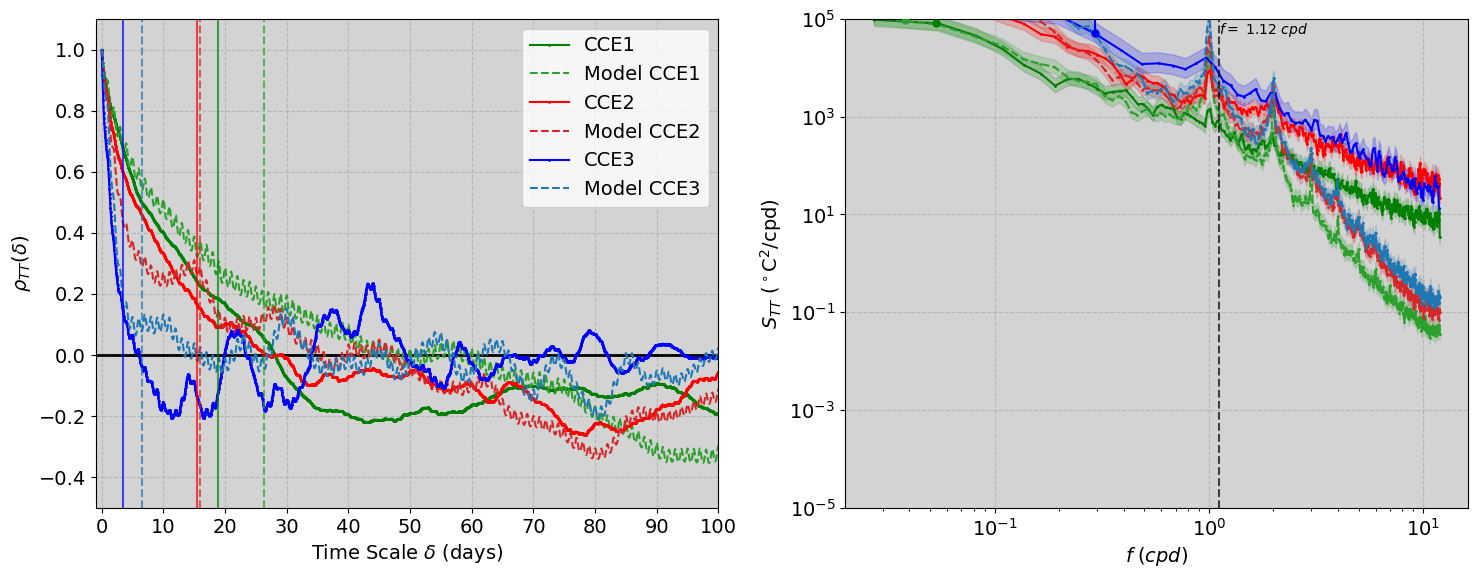

In [ ]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
    ylabel_spec = r'$S_{TT}$ ($^\circ$C$^2$/cpd)'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
    ylabel_spec = r'$S_{SS}$ ($(g/kg)^2$/cpd)'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Convert time scale to days
time_scale_mc_days1 = time_scale_mc1*(1/60)*(1/60)*(1/24)
time_scale_days1 = time_scale1*(1/60)*(1/60)*(1/24)

time_scale_mc_days2 = time_scale_mc2*(1/60)*(1/60)*(1/24)
time_scale_days2 = time_scale2*(1/60)*(1/60)*(1/24)

time_scale_mc_days3 = time_scale_mc3*(1/60)*(1/60)*(1/24)
time_scale_days3 = time_scale3*(1/60)*(1/60)*(1/24)

# Convert to cycles per day
f1_cpd = f1*(60)*(60)*(24)
f2_cpd = f2*(60)*(60)*(24)
f3_cpd = f3*(60)*(60)*(24)
f_mcpd = f_m*(60)*(60)*(24)

# Create figure 
fig, ax = plt.subplots(1,2,figsize=(15, 6))

# Determine upper y-limit from your spectra 
ymin, ymax = 1e-5, 1e5 #1e-2, 1e7 #1e-5, 1e5
ax[1].set_ylim(bottom=ymin, top=ymax)  # Adjust lower limit if needed

#--- Subplot #1 ---# 

# Plot the zero crossing line
ax[0].axhline(0, color='k', linestyle='-', linewidth=2)

# Plot autocorrelations

#--- CCE1 ---# 
ax[0].plot(time_scale_days1[:,0], autocorr1[:,0], '.-', label=f"CCE1", color='green', linewidth=1.5, markersize=2)
ax[0].plot(time_scale_mc_days1, autocorr_mc1, '--', label=f"Model CCE1", color='tab:green', linewidth=1.5, markersize=2)

#--- CCE2 ---# 
ax[0].plot(time_scale_days2[:,0], autocorr2[:,0], '.-', label=f"CCE2", color='red', linewidth=1.5, markersize=2)
ax[0].plot(time_scale_mc_days2, autocorr_mc2, '--', label=f"Model CCE2", color='tab:red', linewidth=1.5, markersize=2)

#--- CCE3 ---# 
ax[0].plot(time_scale_days3[:,0], autocorr3[:,0], '.-', label=f"CCE3", color='blue', linewidth=1.5, markersize=2)
ax[0].plot(time_scale_mc_days3, autocorr_mc3, '--', label=f"Model CCE3", color='tab:blue', linewidth=1.5, markersize=2)

# Plot decorrelation scales
ax[0].axvline(Lt1[0], color='green', linestyle='-', alpha=0.7)
ax[0].axvline(Lt_mc1, color='tab:green', linestyle='--', alpha=0.7)
ax[0].axvline(Lt2[0], color='red', linestyle='-', alpha=0.7)
ax[0].axvline(Lt_mc2, color='tab:red', linestyle='--', alpha=0.7)
ax[0].axvline(Lt3[0], color='blue', linestyle='-', alpha=0.7)
ax[0].axvline(Lt_mc3, color='tab:blue', linestyle='--', alpha=0.7)

# Set legend
ax[0].legend(loc='upper right')

# Set figure attributes
ax[0].set_xlabel(r"Time Scale $\delta$ (days)")
ax[0].set_ylabel(ylabel)
ax[0].set_xlim(-1,100)
ax[0].set_ylim(-0.5,1.1)
ax[0].set_xticks(np.arange(0,110,10))
ax[0].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[0].set_facecolor('lightgray')

#--- Subplot #2 ---# 

# Plot each depth the spectrum, confidence intervals and the decorrelation scale

#--- CCE 1 ---# 
ax[1].loglog(f1_cpd[1:], S1[1:,0], '.-', color='green', linewidth=1.5, markersize=2)
ax[1].fill_between(f1_cpd[1:],CI1[1:,0,0],CI1[1:,1,0],color='green',alpha=0.2)

ax[1].loglog(f_mcpd[1:], S_mc1[1:], '.-', color='tab:green', linewidth=1.5, markersize=2, linestyle='--')
ax[1].fill_between(f_mcpd[1:],CI_mc1[1:,0],CI_mc1[1:,1],color='tab:green',alpha=0.2)

# Interpolate power spectrum at f_i
S_decor1 = np.interp(f_decor1, f1_cpd, S1[:, 0])
S_decor1m = np.interp(f_decor1m, f_mcpd, S_mc1)

# Plot vertical line *only down to the spectrum*
ax[1].plot([f_decor1, f_decor1], [S_decor1, ymax], linestyle='-', color='green', linewidth=1.5)
ax[1].plot([f_decor1m, f_decor1m], [S_decor1m, ymax], linestyle='--', color='tab:green', linewidth=1.5)

# Plot a marker at the intersection point
ax[1].plot(f_decor1, S_decor1, marker='o', color='green', markersize=5, zorder=5)
ax[1].plot(f_decor1m, S_decor1m, marker='o', color='tab:green', markersize=5, zorder=5)

#--- CCE2 ---# 
ax[1].loglog(f2_cpd[1:], S2[1:,0], '.-', color='red', linewidth=1.5, markersize=2)
ax[1].fill_between(f2_cpd[1:],CI2[1:,0,0],CI2[1:,1,0],color='red',alpha=0.2)

ax[1].loglog(f_mcpd[1:], S_mc2[1:], '.-', color='tab:red', linewidth=1.5, markersize=2, linestyle='--')
ax[1].fill_between(f_mcpd[1:],CI_mc2[1:,0],CI_mc2[1:,1],color='tab:red',alpha=0.2)

# Interpolate power spectrum at f_i
S_decor2 = np.interp(f_decor2, f2_cpd, S2[:, 0])
S_decor2m = np.interp(f_decor2m, f_mcpd, S_mc2)

# Plot vertical line *only down to the spectrum*
ax[1].plot([f_decor2, f_decor2], [S_decor2, ymax], linestyle='-', color='red', linewidth=1.5)
ax[1].plot([f_decor2m, f_decor2m], [S_decor2m, ymax], linestyle='--', color='tab:red', linewidth=1.5)

# Plot a marker at the intersection point
ax[1].plot(f_decor2, S_decor2, marker='o', color='red', markersize=5, zorder=5)
ax[1].plot(f_decor2m, S_decor2m, marker='o', color='tab:red', markersize=5, zorder=5)

#--- CCE3 ---# 
ax[1].loglog(f3_cpd[1:], S3[1:,0], '.-', color='blue', linewidth=1.5, markersize=2)
ax[1].fill_between(f3_cpd[1:],CI3[1:,0,0],CI3[1:,1,0],color='blue',alpha=0.2)

ax[1].loglog(f_mcpd[1:], S_mc3[1:], '.-', color='tab:blue', linewidth=1.5, markersize=2, linestyle='--')
ax[1].fill_between(f_mcpd[1:],CI_mc3[1:,0],CI_mc3[1:,1],color='tab:blue',alpha=0.2)

# Interpolate power spectrum at f_i
S_decor3 = np.interp(f_decor3, f3_cpd, S3[:, 0])
S_decor3m = np.interp(f_decor3m, f_mcpd, S_mc3)

# Plot vertical line *only down to the spectrum*
ax[1].plot([f_decor3, f_decor3], [S_decor3, ymax], linestyle='-', color='blue', linewidth=1.5)
ax[1].plot([f_decor3m, f_decor3m], [S_decor3m, ymax], linestyle='--', color='tab:blue', linewidth=1.5)

# Plot a marker at the intersection point
ax[1].plot(f_decor3, S_decor3, marker='o', color='blue', markersize=5, zorder=5)
ax[1].plot(f_decor3m, S_decor3m, marker='o', color='tab:blue', markersize=5, zorder=5)

# Plot the inertial frequency
ax[1].axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
ax[1].text(f_inertial, plt.ylim()[1]*0.6, r'$f = $ ' + str(np.round(f_inertial,2)) + r' $cpd$', rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

# Set figure attributes
ax[1].set_xlabel(r"$f \;(cpd)$")
ax[1].set_ylabel(ylabel_spec)
ax[1].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[1].set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31098/508645439.py:83: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[i, 1].loglog(f_mcpd[1:], S_mc[i][1:], '.-', color=tab_colors[i], linewidth=1.5, markersize=2, linestyle='--')


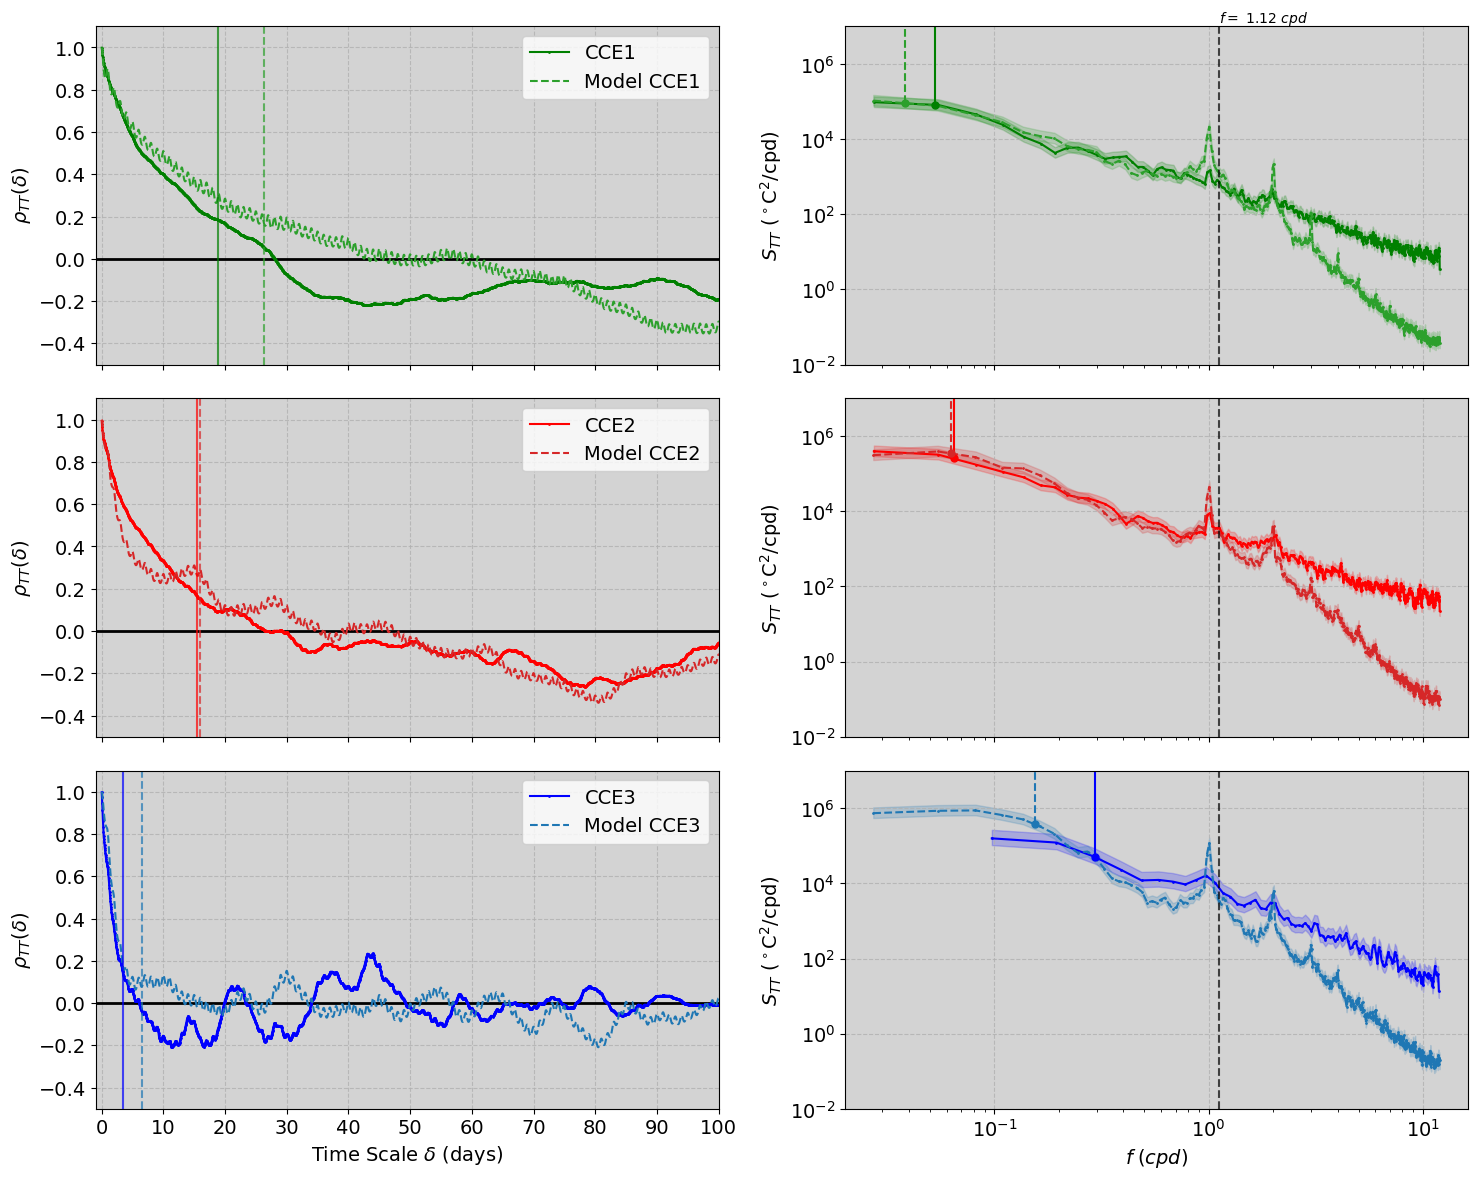

In [ ]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set labels depending on variable
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
    ylabel_spec = r'$S_{TT}$ ($^\circ$C$^2$/cpd)'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
    ylabel_spec = r'$S_{SS}$ ($(g/kg)^2$/cpd)'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Convert time scales to days
def convert_to_days(x):
    return x*(1/60)*(1/60)*(1/24)

time_scale_days = [convert_to_days(ts) for ts in [time_scale1, time_scale2, time_scale3]]
time_scale_mc_days = [convert_to_days(ts_mc) for ts_mc in [time_scale_mc1, time_scale_mc2, time_scale_mc3]]

# Convert frequencies to cycles per day
def convert_to_cpd(f):
    return f*(60)*(60)*(24)

f_cpd = [convert_to_cpd(f) for f in [f1, f2, f3]]
f_mcpd = convert_to_cpd(f_m)

# Set up the figure and axes: 3 rows, 2 columns
fig, ax = plt.subplots(3, 2, figsize=(15, 12), sharex='col')

# Y-limits for spectrum plots
ymin, ymax = 1e-2, 1e7

# Colors and labels for the moorings
colors = ['green', 'red', 'blue']
tab_colors = ['tab:green', 'tab:red', 'tab:blue']
labels = ['CCE1', 'CCE2', 'CCE3']

# Prepare data arrays in lists for looping
autocorrs = [autocorr1, autocorr2, autocorr3]
autocorr_mcs = [autocorr_mc1, autocorr_mc2, autocorr_mc3]
time_scales = time_scale_days
time_scales_mc = time_scale_mc_days
Lt = [Lt1, Lt2, Lt3]
Lt_mc = [Lt_mc1, Lt_mc2, Lt_mc3]
f_cpd_list = f_cpd
S = [S1, S2, S3]
S_mc = [S_mc1, S_mc2, S_mc3]
CI = [CI1, CI2, CI3]
CI_mc = [CI_mc1, CI_mc2, CI_mc3]
f_decor = [f_decor1, f_decor2, f_decor3]
f_decorm = [f_decor1m, f_decor2m, f_decor3m]

# Loop through moorings
for i in range(3):

    # Plot zero crossing
    ax[i, 0].axhline(0, color='k', linestyle='-', linewidth=2)

    # Plot data autocorr
    ax[i, 0].plot(time_scales[i][:,0], autocorrs[i][:,0], '.-', label=labels[i], color=colors[i], linewidth=1.5, markersize=2)
    ax[i, 0].plot(time_scales_mc[i], autocorr_mcs[i], '--', label=f"Model {labels[i]}", color=tab_colors[i], linewidth=1.5, markersize=2)

    # Plot decorrelation scale vertical lines
    ax[i, 0].axvline(Lt[i][0], color=colors[i], linestyle='-', alpha=0.7)
    ax[i, 0].axvline(Lt_mc[i], color=tab_colors[i], linestyle='--', alpha=0.7)

    # Set figure attributes
    ax[i, 0].set_xlim(-1, 100)
    ax[i, 0].set_ylim(-0.5, 1.1)
    ax[i, 0].set_xticks(np.arange(0, 110, 10))
    ax[i, 0].grid(True, linestyle='--', alpha=0.8)
    ax[i, 0].set_facecolor('lightgray')
    ax[i, 0].set_ylabel(ylabel)
    ax[i, 0].legend(loc='upper right')
    if i == 2:
        ax[i, 0].set_xlabel(r"Time Scale $\delta$ (days)")

    # Plot Spectra
    ax[i, 1].loglog(f_cpd_list[i][1:], S[i][1:,0], '.-', color=colors[i], linewidth=1.5, markersize=2)
    ax[i, 1].fill_between(f_cpd_list[i][1:], CI[i][1:,0,0], CI[i][1:,1,0], color=colors[i], alpha=0.2)

    ax[i, 1].loglog(f_mcpd[1:], S_mc[i][1:], '.-', color=tab_colors[i], linewidth=1.5, markersize=2, linestyle='--')
    ax[i, 1].fill_between(f_mcpd[1:], CI_mc[i][1:,0], CI_mc[i][1:,1], color=tab_colors[i], alpha=0.2)

    # Interpolate power spectrum at decorrelation freq
    S_decor_val = np.interp(f_decor[i], f_cpd_list[i], S[i][:,0])
    S_decorm_val = np.interp(f_decorm[i], f_mcpd, S_mc[i])

    # Vertical lines down to spectrum
    ax[i, 1].plot([f_decor[i], f_decor[i]], [S_decor_val, ymax], linestyle='-', color=colors[i], linewidth=1.5)
    ax[i, 1].plot([f_decorm[i], f_decorm[i]], [S_decorm_val, ymax], linestyle='--', color=tab_colors[i], linewidth=1.5)

    # Markers at intersection points
    ax[i, 1].plot(f_decor[i], S_decor_val, marker='o', color=colors[i], markersize=5, zorder=5)
    ax[i, 1].plot(f_decorm[i], S_decorm_val, marker='o', color=tab_colors[i], markersize=5, zorder=5)

    # Inertial frequency line only on bottom subplot (or all if you prefer)
    ax[i, 1].axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
    if i == 0: 
        ax[i, 1].text(f_inertial, ax[i, 1].get_ylim()[1]*0.6, r'$f = $ ' + str(np.round(f_inertial,2)) + r' $cpd$', 
                        rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

    # Set figure attributes
    #ax[i, 1].set_xlim([f_cpd_list[i][1], f_cpd_list[i][-1]])
    ax[i, 1].set_ylim(bottom=ymin, top=ymax)
    ax[i, 1].set_xlabel(r"$f \;(cpd)$" if i == 2 else "")
    ax[i, 1].set_ylabel(ylabel_spec)
    ax[i, 1].grid(True, linestyle='--', alpha=0.8)
    ax[i, 1].set_facecolor('lightgray')

# Show figure
plt.tight_layout()
plt.show()


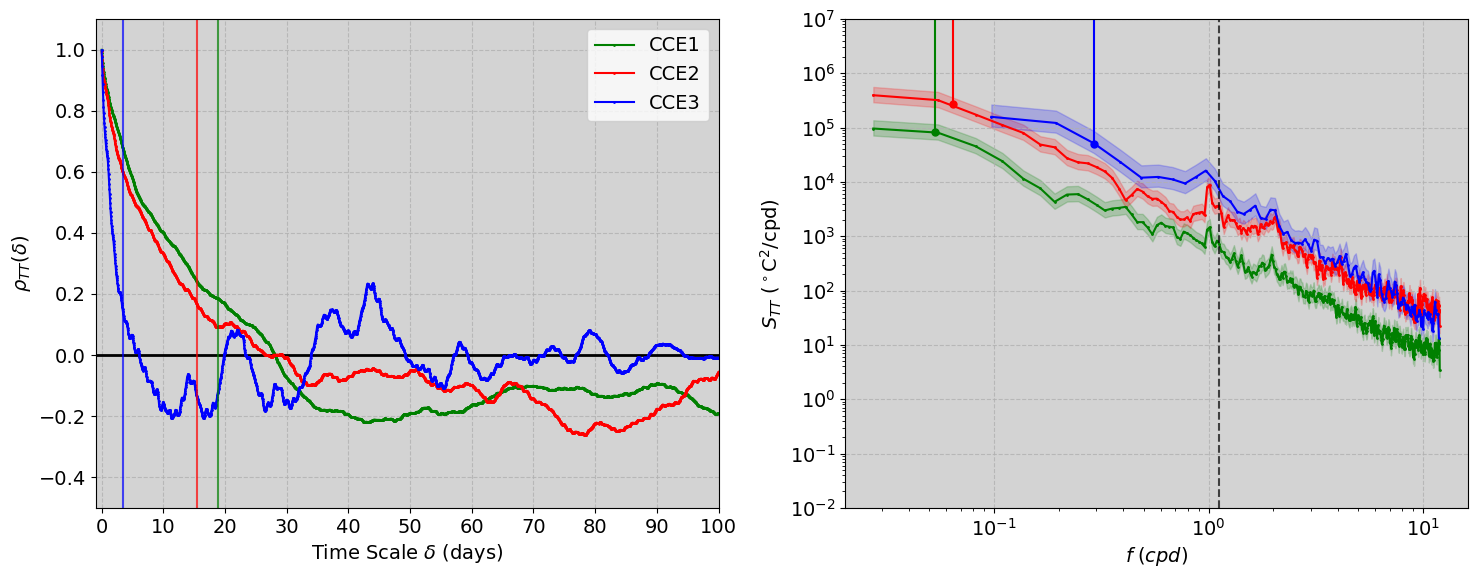

In [ ]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
    ylabel_spec = r'$S_{TT}$ ($^\circ$C$^2$/cpd)'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
    ylabel_spec = r'$S_{SS}$ ($(g/kg)^2$/cpd)'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Convert time scale to days
time_scale_mc_days1 = time_scale_mc1*(1/60)*(1/60)*(1/24)
time_scale_days1 = time_scale1*(1/60)*(1/60)*(1/24)

time_scale_mc_days2 = time_scale_mc2*(1/60)*(1/60)*(1/24)
time_scale_days2 = time_scale2*(1/60)*(1/60)*(1/24)

time_scale_mc_days3 = time_scale_mc3*(1/60)*(1/60)*(1/24)
time_scale_days3 = time_scale3*(1/60)*(1/60)*(1/24)

# Convert to cycles per day
f1_cpd = f1*(60)*(60)*(24)
f2_cpd = f2*(60)*(60)*(24)
f3_cpd = f3*(60)*(60)*(24)
f_mcpd = f_m*(60)*(60)*(24)

# Create figure 
fig, ax = plt.subplots(1,2,figsize=(15, 6))

# Determine upper y-limit from your spectra 
ymin, ymax = 1e-2, 1e7 #1e-2, 1e7 #1e-5, 1e5
ax[1].set_ylim(bottom=ymin, top=ymax)  # Adjust lower limit if needed

#--- Subplot #1 ---# 

# Plot the zero crossing line
ax[0].axhline(0, color='k', linestyle='-', linewidth=2)

# Plot autocorrelations

#--- CCE1 ---# 
ax[0].plot(time_scale_days1[:,0], autocorr1[:,0], '.-', label=f"CCE1", color='green', linewidth=1.5, markersize=2)
#ax[0].plot(time_scale_mc_days1, autocorr_mc1, '--', label=f"Model CCE1", color='tab:green', linewidth=1.5, markersize=2)

#--- CCE2 ---# 
ax[0].plot(time_scale_days2[:,0], autocorr2[:,0], '.-', label=f"CCE2", color='red', linewidth=1.5, markersize=2)
#ax[0].plot(time_scale_mc_days2, autocorr_mc2, '--', label=f"Model CCE2", color='tab:red', linewidth=1.5, markersize=2)

#--- CCE3 ---# 
ax[0].plot(time_scale_days3[:,0], autocorr3[:,0], '.-', label=f"CCE3", color='blue', linewidth=1.5, markersize=2)
#ax[0].plot(time_scale_mc_days3, autocorr_mc3, '--', label=f"Model CCE3", color='tab:blue', linewidth=1.5, markersize=2)

# Plot decorrelation scales
ax[0].axvline(Lt1[0], color='green', linestyle='-', alpha=0.7)
#ax[0].axvline(Lt_mc1, color='tab:green', linestyle='--', alpha=0.7)
ax[0].axvline(Lt2[0], color='red', linestyle='-', alpha=0.7)
#ax[0].axvline(Lt_mc2, color='tab:red', linestyle='--', alpha=0.7)
ax[0].axvline(Lt3[0], color='blue', linestyle='-', alpha=0.7)
#ax[0].axvline(Lt_mc3, color='tab:blue', linestyle='--', alpha=0.7)

# Set legend
ax[0].legend(loc='upper right')

# Set figure attributes
ax[0].set_xlabel(r"Time Scale $\delta$ (days)")
ax[0].set_ylabel(ylabel)
ax[0].set_xlim(-1,100)
ax[0].set_ylim(-0.5,1.1)
ax[0].set_xticks(np.arange(0,110,10))
ax[0].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[0].set_facecolor('lightgray')

#--- Subplot #2 ---# 

# Plot each depth the spectrum, confidence intervals and the decorrelation scale

#--- CCE 1 ---# 
ax[1].loglog(f1_cpd[1:], S1[1:,0], '.-', color='green', linewidth=1.5, markersize=2)
ax[1].fill_between(f1_cpd[1:],CI1[1:,0,0],CI1[1:,1,0],color='green',alpha=0.2)

#ax[1].loglog(f_mcpd[1:], S_mc1[1:], '.-', color='tab:green', linewidth=1.5, markersize=2, linestyle='--')
#ax[1].fill_between(f_mcpd[1:],CI_mc1[1:,0],CI_mc1[1:,1],color='tab:green',alpha=0.2)

# Interpolate power spectrum at f_i
S_decor1 = np.interp(f_decor1, f1_cpd, S1[:, 0])
#S_decor1m = np.interp(f_decor1m, f_mcpd, S_mc1)

# Plot vertical line *only down to the spectrum*
ax[1].plot([f_decor1, f_decor1], [S_decor1, ymax], linestyle='-', color='green', linewidth=1.5)
#ax[1].plot([f_decor1m, f_decor1m], [S_decor1m, ymax], linestyle='--', color='tab:green', linewidth=1.5)

# Plot a marker at the intersection point
ax[1].plot(f_decor1, S_decor1, marker='o', color='green', markersize=5, zorder=5)
#ax[1].plot(f_decor1m, S_decor1m, marker='o', color='tab:green', markersize=5, zorder=5)

#--- CCE2 ---# 
ax[1].loglog(f2_cpd[1:], S2[1:,0], '.-', color='red', linewidth=1.5, markersize=2)
ax[1].fill_between(f2_cpd[1:],CI2[1:,0,0],CI2[1:,1,0],color='red',alpha=0.2)

#ax[1].loglog(f_mcpd[1:], S_mc2[1:], '.-', color='tab:red', linewidth=1.5, markersize=2, linestyle='--')
#ax[1].fill_between(f_mcpd[1:],CI_mc2[1:,0],CI_mc2[1:,1],color='tab:red',alpha=0.2)

# Interpolate power spectrum at f_i
S_decor2 = np.interp(f_decor2, f2_cpd, S2[:, 0])
#S_decor2m = np.interp(f_decor2m, f_mcpd, S_mc2)

# Plot vertical line *only down to the spectrum*
ax[1].plot([f_decor2, f_decor2], [S_decor2, ymax], linestyle='-', color='red', linewidth=1.5)
#ax[1].plot([f_decor2m, f_decor2m], [S_decor2m, ymax], linestyle='--', color='tab:red', linewidth=1.5)

# Plot a marker at the intersection point
ax[1].plot(f_decor2, S_decor2, marker='o', color='red', markersize=5, zorder=5)
#ax[1].plot(f_decor2m, S_decor2m, marker='o', color='tab:red', markersize=5, zorder=5)

#--- CCE3 ---# 
ax[1].loglog(f3_cpd[1:], S3[1:,0], '.-', color='blue', linewidth=1.5, markersize=2)
ax[1].fill_between(f3_cpd[1:],CI3[1:,0,0],CI3[1:,1,0],color='blue',alpha=0.2)

#ax[1].loglog(f_mcpd[1:], S_mc3[1:], '.-', color='tab:blue', linewidth=1.5, markersize=2, linestyle='--')
#ax[1].fill_between(f_mcpd[1:],CI_mc3[1:,0],CI_mc3[1:,1],color='tab:blue',alpha=0.2)

# Interpolate power spectrum at f_i
S_decor3 = np.interp(f_decor3, f3_cpd, S3[:, 0])
#S_decor3m = np.interp(f_decor3m, f_mcpd, S_mc3)

# Plot vertical line *only down to the spectrum*
ax[1].plot([f_decor3, f_decor3], [S_decor3, ymax], linestyle='-', color='blue', linewidth=1.5)
#ax[1].plot([f_decor3m, f_decor3m], [S_decor3m, ymax], linestyle='--', color='tab:blue', linewidth=1.5)

# Plot a marker at the intersection point
ax[1].plot(f_decor3, S_decor3, marker='o', color='blue', markersize=5, zorder=5)
#ax[1].plot(f_decor3m, S_decor3m, marker='o', color='tab:blue', markersize=5, zorder=5)

# Plot the inertial frequency
ax[1].axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
#ax[1].text(f_inertial, plt.ylim()[1]*0.6, r'$f = $ ' + str(np.round(f_inertial,2)) + r' $cpd$', rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

# Set figure attributes
ax[1].set_xlabel(r"$f \;(cpd)$")
ax[1].set_ylabel(ylabel_spec)
ax[1].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[1].set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31098/4140204650.py:86: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[1].loglog(f_mcpd[1:], S_mc1[1:], '.-', color='tab:green', linewidth=1.5, markersize=2, linestyle='-')
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31098/4140204650.py:105: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[1].loglog(f_mcpd[1:], S_mc2[1:], '.-', color='tab:red', linewidth=1.5, markersize=2, linestyle='-')
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_31098/4140204650.py:124: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[1].loglog(f_mcpd[1:], S_m

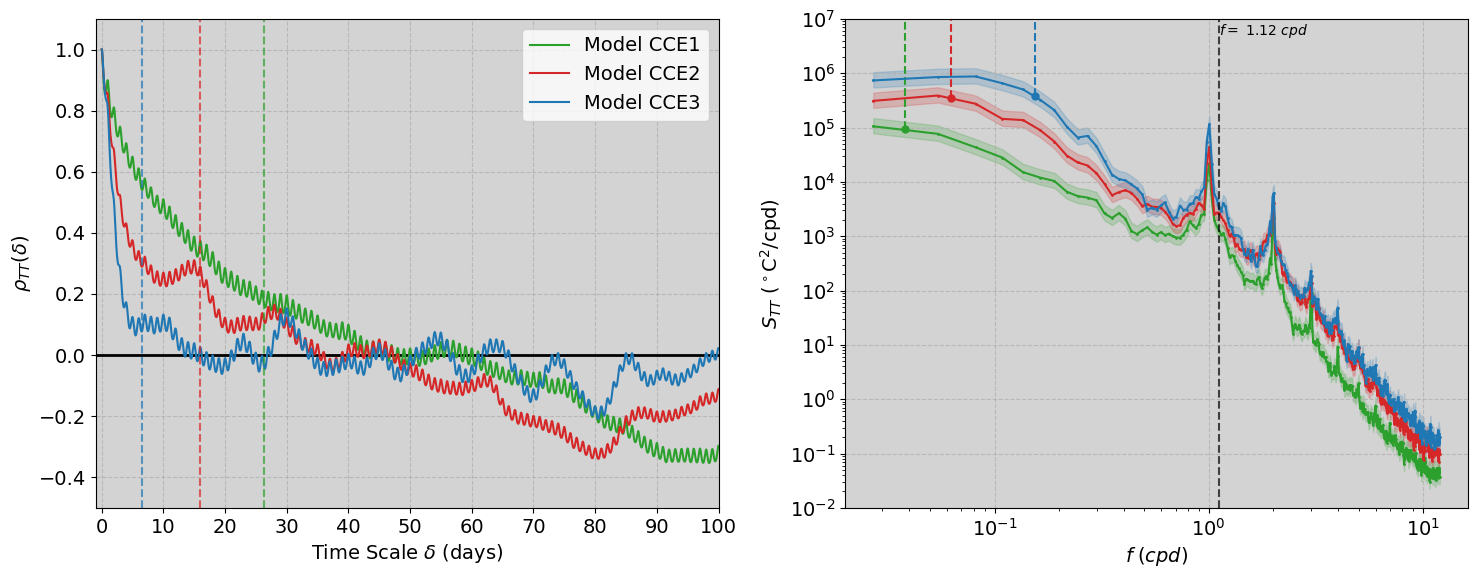

In [ ]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
    ylabel_spec = r'$S_{TT}$ ($^\circ$C$^2$/cpd)'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
    ylabel_spec = r'$S_{SS}$ ($(g/kg)^2$/cpd)'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Convert time scale to days
time_scale_mc_days1 = time_scale_mc1*(1/60)*(1/60)*(1/24)
time_scale_days1 = time_scale1*(1/60)*(1/60)*(1/24)

time_scale_mc_days2 = time_scale_mc2*(1/60)*(1/60)*(1/24)
time_scale_days2 = time_scale2*(1/60)*(1/60)*(1/24)

time_scale_mc_days3 = time_scale_mc3*(1/60)*(1/60)*(1/24)
time_scale_days3 = time_scale3*(1/60)*(1/60)*(1/24)

# Convert to cycles per day
f1_cpd = f1*(60)*(60)*(24)
f2_cpd = f2*(60)*(60)*(24)
f3_cpd = f3*(60)*(60)*(24)
f_mcpd = f_m*(60)*(60)*(24)

# Create figure 
fig, ax = plt.subplots(1,2,figsize=(15, 6))

# Determine upper y-limit from your spectra 
ymin, ymax = 1e-2, 1e7 #1e-2, 1e7 #1e-5, 1e5
ax[1].set_ylim(bottom=ymin, top=ymax)  # Adjust lower limit if needed

#--- Subplot #1 ---# 

# Plot the zero crossing line
ax[0].axhline(0, color='k', linestyle='-', linewidth=2)

# Plot autocorrelations

#--- CCE1 ---# 
#ax[0].plot(time_scale_days1[:,0], autocorr1[:,0], '.-', label=f"CCE1", color='green', linewidth=1.5, markersize=2)
ax[0].plot(time_scale_mc_days1, autocorr_mc1, '-', label=f"Model CCE1", color='tab:green', linewidth=1.5, markersize=2)

#--- CCE2 ---# 
#ax[0].plot(time_scale_days2[:,0], autocorr2[:,0], '.-', label=f"CCE2", color='red', linewidth=1.5, markersize=2)
ax[0].plot(time_scale_mc_days2, autocorr_mc2, '-', label=f"Model CCE2", color='tab:red', linewidth=1.5, markersize=2)

#--- CCE3 ---# 
#ax[0].plot(time_scale_days3[:,0], autocorr3[:,0], '.-', label=f"CCE3", color='blue', linewidth=1.5, markersize=2)
ax[0].plot(time_scale_mc_days3, autocorr_mc3, '-', label=f"Model CCE3", color='tab:blue', linewidth=1.5, markersize=2)

# Plot decorrelation scales
#ax[0].axvline(Lt1[0], color='green', linestyle='-', alpha=0.7)
ax[0].axvline(Lt_mc1, color='tab:green', linestyle='--', alpha=0.7)
#ax[0].axvline(Lt2[0], color='red', linestyle='-', alpha=0.7)
ax[0].axvline(Lt_mc2, color='tab:red', linestyle='--', alpha=0.7)
#ax[0].axvline(Lt3[0], color='blue', linestyle='-', alpha=0.7)
ax[0].axvline(Lt_mc3, color='tab:blue', linestyle='--', alpha=0.7)

# Set legend
ax[0].legend(loc='upper right')

# Set figure attributes
ax[0].set_xlabel(r"Time Scale $\delta$ (days)")
ax[0].set_ylabel(ylabel)
ax[0].set_xlim(-1,100)
ax[0].set_ylim(-0.5,1.1)
ax[0].set_xticks(np.arange(0,110,10))
ax[0].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[0].set_facecolor('lightgray')

#--- Subplot #2 ---# 

# Plot each depth the spectrum, confidence intervals and the decorrelation scale

#--- CCE 1 ---# 
#ax[1].loglog(f1_cpd[1:], S1[1:,0], '.-', color='green', linewidth=1.5, markersize=2)
#ax[1].fill_between(f1_cpd[1:],CI1[1:,0,0],CI1[1:,1,0],color='green',alpha=0.2)

ax[1].loglog(f_mcpd[1:], S_mc1[1:], '.-', color='tab:green', linewidth=1.5, markersize=2, linestyle='-')
ax[1].fill_between(f_mcpd[1:],CI_mc1[1:,0],CI_mc1[1:,1],color='tab:green',alpha=0.2)

# Interpolate power spectrum at f_i
#S_decor1 = np.interp(f_decor1, f1_cpd, S1[:, 0])
S_decor1m = np.interp(f_decor1m, f_mcpd, S_mc1)

# Plot vertical line *only down to the spectrum*
#ax[1].plot([f_decor1, f_decor1], [S_decor1, ymax], linestyle='-', color='green', linewidth=1.5)
ax[1].plot([f_decor1m, f_decor1m], [S_decor1m, ymax], linestyle='--', color='tab:green', linewidth=1.5)

# Plot a marker at the intersection point
#ax[1].plot(f_decor1, S_decor1, marker='o', color='green', markersize=5, zorder=5)
ax[1].plot(f_decor1m, S_decor1m, marker='o', color='tab:green', markersize=5, zorder=5)

#--- CCE2 ---# 
#ax[1].loglog(f2_cpd[1:], S2[1:,0], '.-', color='red', linewidth=1.5, markersize=2)
#ax[1].fill_between(f2_cpd[1:],CI2[1:,0,0],CI2[1:,1,0],color='red',alpha=0.2)

ax[1].loglog(f_mcpd[1:], S_mc2[1:], '.-', color='tab:red', linewidth=1.5, markersize=2, linestyle='-')
ax[1].fill_between(f_mcpd[1:],CI_mc2[1:,0],CI_mc2[1:,1],color='tab:red',alpha=0.2)

# Interpolate power spectrum at f_i
#S_decor2 = np.interp(f_decor2, f2_cpd, S2[:, 0])
S_decor2m = np.interp(f_decor2m, f_mcpd, S_mc2)

# Plot vertical line *only down to the spectrum*
#ax[1].plot([f_decor2, f_decor2], [S_decor2, ymax], linestyle='-', color='red', linewidth=1.5)
ax[1].plot([f_decor2m, f_decor2m], [S_decor2m, ymax], linestyle='--', color='tab:red', linewidth=1.5)

# Plot a marker at the intersection point
#ax[1].plot(f_decor2, S_decor2, marker='o', color='red', markersize=5, zorder=5)
ax[1].plot(f_decor2m, S_decor2m, marker='o', color='tab:red', markersize=5, zorder=5)

#--- CCE3 ---# 
#ax[1].loglog(f3_cpd[1:], S3[1:,0], '.-', color='blue', linewidth=1.5, markersize=2)
#ax[1].fill_between(f3_cpd[1:],CI3[1:,0,0],CI3[1:,1,0],color='blue',alpha=0.2)

ax[1].loglog(f_mcpd[1:], S_mc3[1:], '.-', color='tab:blue', linewidth=1.5, markersize=2, linestyle='-')
ax[1].fill_between(f_mcpd[1:],CI_mc3[1:,0],CI_mc3[1:,1],color='tab:blue',alpha=0.2)

# Interpolate power spectrum at f_i
#S_decor3 = np.interp(f_decor3, f3_cpd, S3[:, 0])
S_decor3m = np.interp(f_decor3m, f_mcpd, S_mc3)

# Plot vertical line *only down to the spectrum*
#ax[1].plot([f_decor3, f_decor3], [S_decor3, ymax], linestyle='-', color='blue', linewidth=1.5)
ax[1].plot([f_decor3m, f_decor3m], [S_decor3m, ymax], linestyle='--', color='tab:blue', linewidth=1.5)

# Plot a marker at the intersection point
#ax[1].plot(f_decor3, S_decor3, marker='o', color='blue', markersize=5, zorder=5)
ax[1].plot(f_decor3m, S_decor3m, marker='o', color='tab:blue', markersize=5, zorder=5)

# Plot the inertial frequency
ax[1].axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
ax[1].text(f_inertial, plt.ylim()[1]*0.6, r'$f = $ ' + str(np.round(f_inertial,2)) + r' $cpd$', rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

# Set figure attributes
ax[1].set_xlabel(r"$f \;(cpd)$")
ax[1].set_ylabel(ylabel_spec)
ax[1].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[1].set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Plot the decorrelation scale at each mooring

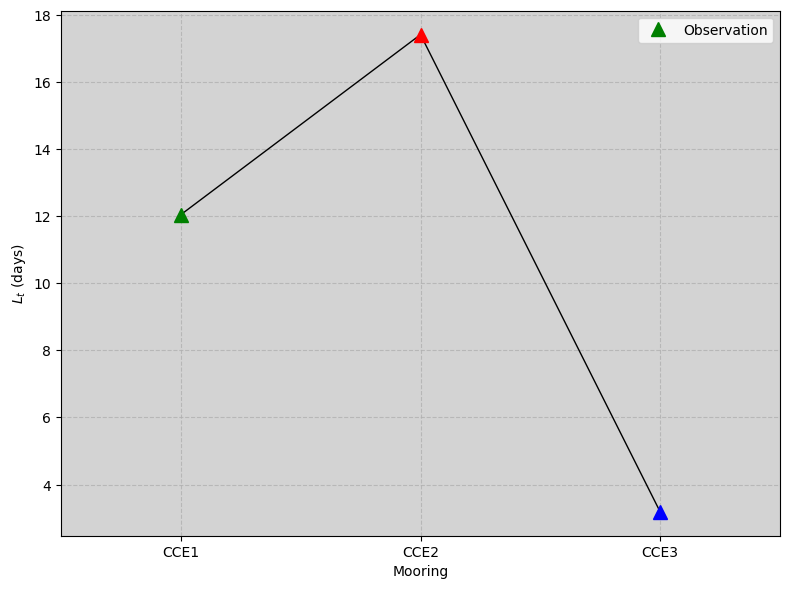

In [ ]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot the decorrelation length scale
ax.plot([1,2,3], [Lt1[0], Lt2[0], Lt3[0]],'k-', linewidth='1')
#ax.plot([1,2,3], [Lt_mc1, Lt_mc2, Lt_mc3], 'k--', linewidth='1')
ax.plot(1, Lt1[0], '^', color='green', markersize=10, label='Observation')
#ax.plot(1, Lt_mc1, 'o', color='tab:green', markersize=10, label='Model')
ax.plot(2, Lt2[0], '^', color='red', markersize=10)
#ax.plot(2, Lt_mc2, 'o', color='tab:red', markersize=10)
ax.plot(3, Lt3[0], '^', color='blue', markersize=10)
#ax.plot(3, Lt_mc3, 'o', color='tab:blue', markersize=10)

# Set figure attributes
ax.set_xlabel('Mooring')
ax.set_ylabel(r'$L_t$ (days)')
ax.set_xlim([0.5,3.5])
ax.set_xticks([1,2,3])
ax.set_xticklabels(['CCE1', 'CCE2', 'CCE3'])
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

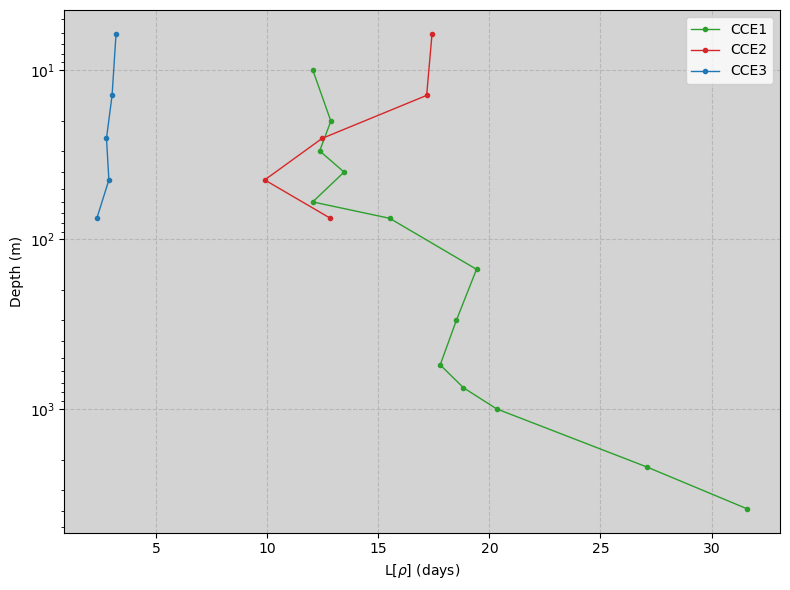

In [ ]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot the decorrelation length scale
ax.semilogy(Lt1, depth1, '.-', color='tab:green', linewidth=1,label='CCE1')
ax.semilogy(Lt2, depth2, '.-', color='tab:red', linewidth=1, label='CCE2')
ax.semilogy(Lt3, depth3, '.-', color='tab:blue', linewidth=1, label='CCE3')

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Depth (m)')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Compute the absolute difference and log ratio between the observed and modeled spectra

In [ ]:
# # Interpolate model frequency grid onto the observation's frequency grid 
# f1_cpd, f_mcpd, S_mc1


# #--- Observed vs. Modeled Spectra ---# 
# abs_diff_CCE1 = np.abs(S1 - S_mc1)